# Optimization Algorithms

In [2]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


### Why Mini-Batches?

When using mini batches we have more chances to update the weights

In [3]:
num_samples = 1000
batch_size = 32

# Batch Gradient Descent
batch_gd_updates = 0
for epoch in range(10):
    batch_gd_updates += 1
print(f"Batch Gradient Descent - Number of chances to update the weights: {batch_gd_updates}")

# Mini-batch Gradient Descent
mini_batch_gd_updates = 0
for epoch in range(10):
    for i in range(0, num_samples, batch_size):
        mini_batch_gd_updates += 1
print(f"Mini-batch Gradient Descent - Number of chances to update the weights: {mini_batch_gd_updates}")

Batch Gradient Descent - Number of chances to update the weights: 10
Mini-batch Gradient Descent - Number of chances to update the weights: 320


How to choose batch size?

In [4]:
# Mini-batch Gradient Descent
for bs in range(1, 5):
    mini_batch_gd_updates = 0
    for epoch in range(10):
        for i in range(0, num_samples, batch_size):
            mini_batch_gd_updates += 1
    print(f"When bs={bs} - Number of chances to update the weights: {mini_batch_gd_updates}")


When bs=1 - Number of chances to update the weights: 320
When bs=2 - Number of chances to update the weights: 320
When bs=3 - Number of chances to update the weights: 320
When bs=4 - Number of chances to update the weights: 320


No matter the batch size, we have the same number of chances to update the weights, what is the difference then? To answer this question, we need to look at the loss lanscape.

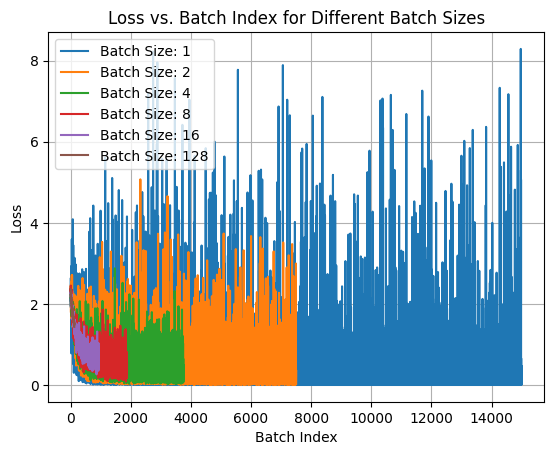

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import torchvision.transforms as transforms


def pil_images_to_tensor(pil_images):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    image_tensors = [transform(image) for image in pil_images]
    image_tensor = torch.stack(image_tensors)
    m, c, h, w = image_tensor.shape
    image_tensor = image_tensor.view(m, c * h * w)
    return image_tensor


# Dataset and Dataloader
ds = load_dataset("mnist")
train_ds = ds['train'].train_test_split(test_size=0.95, seed=42)  # taking only 5% samples
train_x = pil_images_to_tensor(train_ds['train']['image'])
train_y = torch.tensor(train_ds['train']['label'], dtype=torch.long)
num_samples = len(train_y)
dataset = TensorDataset(train_x, train_y)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        return self.linear(x)


# Trainer
def train_model(model, dataloader, num_epochs):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    batch_losses = []
    for _ in range(num_epochs):
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = nn.CrossEntropyLoss()(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
    return batch_losses


# Experiment training the model with different batch sizes
# plt.figure(figsize=(10, 6))
for batch_size in [1, 2, 4, 8, 16, 128]:
    batch_losses = train_model(MNISTClassifier(),
                               DataLoader(dataset, batch_size=batch_size, shuffle=True),
                               num_epochs=5)
    
    batch_indices = range(1, len(batch_losses) + 1)
    plt.plot(batch_indices, batch_losses, label=f"Batch Size: {batch_size}", linestyle='-', linewidth=1.5)

plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Loss vs. Batch Index for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.show()

### Exponentially Weighted (Moving) Averages

Gradient descent is a fundamental optimization algorithm used to train machine learning models. However, the vanilla gradient descent can sometimes lead to slow convergence or get stuck in suboptimal solutions. In this article, we will explore several improvements made to gradient descent, focusing on Momentum and Adam optimizers.

The goal of optimization is to find the best fit for the data points without overfitting or underfitting. We want to strike a balance between capturing the underlying patterns and avoiding excessive noise. This is where the concept of moving average comes into play. Looking at the plot below, what is the best way to fit these points?

/var/folders/4w/_b4hnggd48d_185jzp3t9xvr0000gp/T/ipykernel_54621/1373222276.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


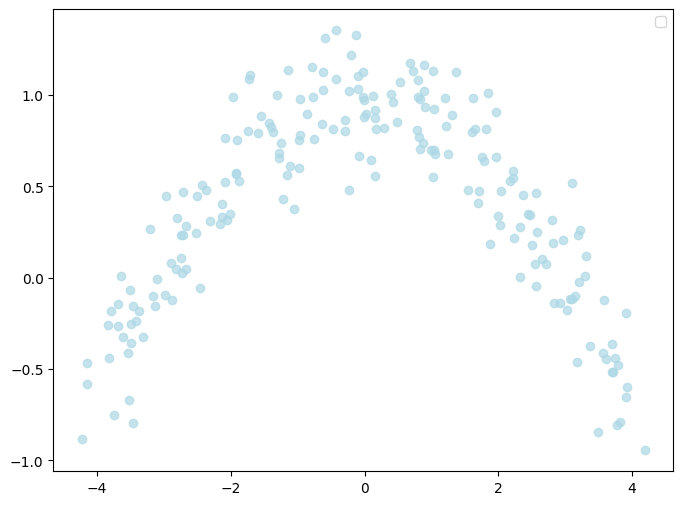

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-4, 4, 200)
y = 1 - (x/3) ** 2

# Increase the standard deviation to add more variance
x1 = x + np.random.randn(200) * 0.2
y1 = y + np.random.randn(200) * 0.2

plt.figure(figsize=(8, 6))
plt.scatter(x1, y1, color='lightblue', alpha=0.7)
plt.legend()
plt.show()

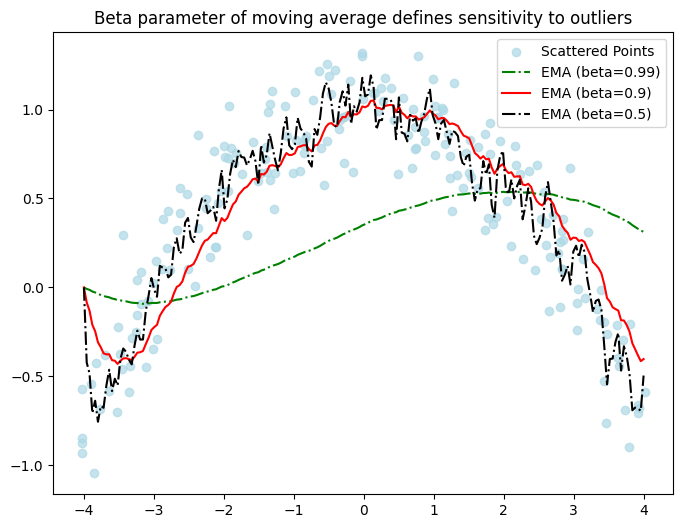

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def exponential_moving_average(beta, y):
    vt = np.zeros_like(y)
    for i in range(1, len(y)):
        vt[i] = beta * vt[i-1] + (1-beta) * y[i]
    return vt

x = np.linspace(-4, 4, 200)
y = 1 - (x/3) ** 2

# Increase the standard deviation to add more variance
x1 = x + np.random.randn(200) * 0.2
y1 = y + np.random.randn(200) * 0.2

plt.figure(figsize=(8, 6))
plt.scatter(x1, y1, color='lightblue', alpha=0.7, label='Scattered Points')
plt.plot(x, exponential_moving_average(0.99, y1), color='green', linestyle='-.', label='EMA (beta=0.99)')
plt.plot(x, exponential_moving_average(0.9, y1), color='red', linestyle='-', label='EMA (beta=0.9)')
plt.plot(x, exponential_moving_average(0.5, y1), color='black', linestyle='-.', label='EMA (beta=0.5)')
plt.title('Beta parameter of moving average defines sensitivity to outliers')
plt.legend()
plt.show()

- The black curve adapts more quickly but also means it's more sensitive to outliers, think about a ping pong ball rolling down a mountain and going through every little crevasses.
- The red curve is more smooth but less sensitive to outliers, think about a basket ball rolling down a mountain and not taking in consideration tiny depressions.
- The green curve is like a boulder rolling the mountain, it doesn't take in consideration much, so it doesn't adapt much

### Bias Correction

As we can see above, the red line is not great, especially at the beginning. The issue is that when we jump from the first few v0, v1 etc, the exponential moving average is still warming up we don't have enough values to compute a good average yet.

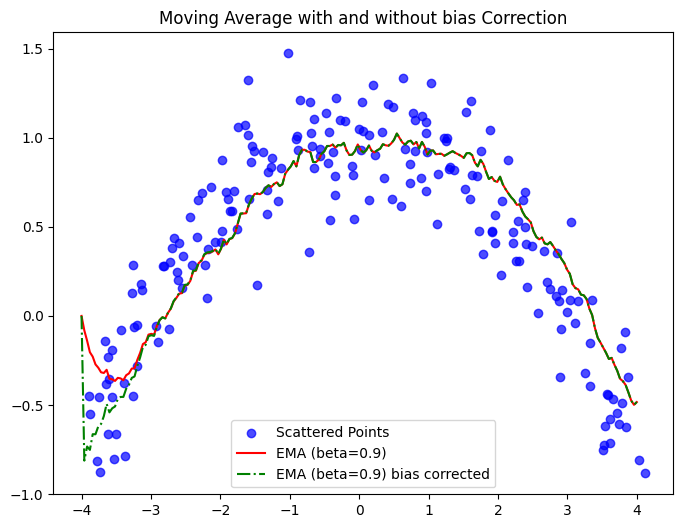

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def exponential_moving_average(beta, y):
    vt = np.zeros_like(y)
    for i in range(1, len(y)):
        vt[i] = beta * vt[i-1] + (1-beta) * y[i]
    return vt

def exponential_moving_average_bias_corrected(beta, y):
    vt = np.zeros_like(y)
    vt_corrected = np.zeros_like(y)
    for i in range(1, len(y)):
        vt[i] = beta * vt[i-1] + (1-beta) * y[i]
        vt_corrected[i] = vt[i] / (1 - beta ** i)
    return vt_corrected

x = np.linspace(-4, 4, 200)
y = 1 - (x/3) ** 2

# Increase the standard deviation to add more variance
x1 = x + np.random.randn(200) * 0.2
y1 = y + np.random.randn(200) * 0.2

plt.figure(figsize=(8, 6))
plt.scatter(x1, y1, color='blue', alpha=0.7, label='Scattered Points')
plt.plot(x, exponential_moving_average(0.9, y1), color='red', linestyle='-', label='EMA (beta=0.9)')
plt.plot(x, exponential_moving_average_bias_corrected(0.9, y1), color='green', linestyle='-.', label='EMA (beta=0.9) bias corrected')
plt.title('Moving Average with and without bias Correction')
plt.legend()
plt.show()

### Momentum

Momentum takes the idea of moving averages and apply it gradient descent. While before we would apply the latest gradient to the weights without question. With momentum we take an average of the last gradients, the results is that it smoothes out the steps of gradient descent.

In [14]:
# note the default of beta to 0.9
def update_weights_with_momentum(weights, cache, lr, beta=0.9):
    # vdW is the moving average of the last gradients
    # - beta: represents friction to that ball
    # - vdW: represents a velocity
    # - (1 - beta) * dW: can be seen as acceleration of a ball rolling down a hill
    #
    # -> In a nutshell: we could say that we take a certain amount of the average gradients from the past x observations
    cache['vdW'] = beta * cache['vdW'] + (1 - beta) * cache['dW']
    cache['vdb'] = beta * cache['vdb'] + (1 - beta) * cache['db']
    
    # update weights using momentum instead of raw gradients
    weights['W'] -= lr * cache['vdW']
    weights['b'] -= lr * cache['vdb']

Question is, what should be the value of beta? How many past gradients do we want to take in consideration?
This is a hyperparameter that you will need to tune. But in general a common default is 0.9.

### RMSProp

Yet another way to make the learning rate more adaptive, is RMSProp.

> Fun fact is that RMSProp did not come out from a research paper but instead during a coursera class of by Geoffrey Hinton in Lecture 6e of his Coursera class "Neural Networks for Machine Learning".

The idea is that instead of using a single learning rate for every parameter, we would allow each parameter to get its own learning rate which is controlled by a global learning rate. That way we can give more importance to some weights and less for some others.

How do we know which one deserve mores importance? We can keep track of a parameter's gradient, if it hasn't moved for a while then we can give it more importance.

That way we can give more importance to some weights and less for some others.

And how do we do that exactly? It's actually very simple. In statistics if you want to give more importance to outliers you use square, that's it!

__RMSProp stands for Root Mean Squared Propagation__

In [1]:
# # note the default of beta2 is 0.999
# value of epsilon doesn't really matter, we just want a small value
def update_weights_with_rmsprop(weights, cache, lr, beta2=0.999, epsilon=1e-8):
    # the only thing that changed is the square!
    cache['sdW'] = beta2 * cache['sdW'] + (1 - beta2) * cache['dW'] ** 2
    cache['sdb'] = beta2 * cache['sdb'] + (1 - beta2) * cache['db'] ** 2
    
    # Since we did the square, we need to bring back the value, we can do that with sqrt()
    # if sqrt(dsdW) is very close to zero it would blow up
    # so we need to add a value epsilon to ensure numerical stability
    weights['W'] -= lr * (cache['dW'] / torch.sqrt(cache['sdW'] + epsilon))
    weights['b'] -= lr * (cache['sdb'] / torch.sqrt(cache['sdb'] + epsilon))

### Adam

First let's summarize:
- Momentum is the idea of moving average, taking a velocity and average over x observations
- RMSProp is the idea of updating more the weights that need it most and less weights that need it less

Adam combines the idea of momentum and RMSProp together. You may ask, why not just use RMSProp?

__Adam stands for Adapative Moment Estimation__, looking back at the RMSProp code, it might seem that there is a form of momentum, but actually the momentum gets overshadow by the ratio of gradients over momentum:



In [13]:
# weights['W'] -= lr * (cache['dW'] / torch.sqrt(cache['sdW'] + epsilon))

The idea is to bring back the momentum in the numerator instead of the gradients, a slight but significant difference!

In [14]:
# t: represents the iteration number
def update_weights_with_adam(t, weights, cache, lr, beta1=0.9, beta2=0.99, epsilon=1e-8):
    # We will just gonna focus on W just for illustration purpose

    # Momentum
    cache['vdW'] = beta1 * cache['vdW'] + (1 - beta1) * cache['dW']

    # RMSProp
    cache['sdW'] = beta2 * cache['sdW'] + (1 - beta2) * cache['dW'] ** 2

    # V after bias correction
    cache['vdW_corrected'] = cache['vdW'] / (1-beta1 ** t)
    cache['sdW_corrected'] = cache['sdW'] / (1-beta2 ** t)
    
    weights['W'] -= lr * (cache['vdW_corrected'] / torch.sqrt(cache['sdW'] + epsilon))


So we got hyper parameters:
- `beta1` for momentum which is usually 0.9
- `beta2` for RMSProp which is usually 0.999
- `epsilon` usually set to a small number such as 1e-8

In general these hyperparam are rarely tuned and kept as default.

Adam adapts the learning rates for each parameter by incorporating ideas from both RMSprop and momentum optimization. It maintains a moving average of the gradients (first moment) and the squared gradients (second moment) to scale the learning rates based on the historical magnitudes and directions of the gradients.